In [1]:
import numpy as np
import tensorflow as tf
import flowpm
import tensorflow_probability as tfp

In [2]:
cosmo={"w0":-1.0,
       "wa":0.0,
       "H0":100,
       "h":0.6774,
       "Omega0_b":0.04860,
       "Omega0_c":0.2589,
       "Omega0_m":0.3075,
       "Omega0_k":0.0,
       "Omega0_de":0.6925,
       "n_s":0.9667,
       "sigma8":0.8159}

# Planck 2015 paper XII Table 4 final column (best fit)

In [3]:
def fde(cosmo,a,epsilon=1e-5):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    w0=tf.convert_to_tensor(cosmo["w0"],dtype=tf.float32)
    wa=tf.convert_to_tensor(cosmo["wa"],dtype=tf.float32)
    return (-3.0*(1.0+w0)+
            3.0*wa*((a-1.0)/tf.math.log(a-epsilon)-1.0))

print(fde(cosmo,0.5))

tf.Tensor(-0.0, shape=(), dtype=float32)


In [4]:
def w(cosmo,a):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    w0=tf.convert_to_tensor(cosmo["w0"],dtype=tf.float32)
    wa=tf.convert_to_tensor(cosmo["wa"],dtype=tf.float32)
    return w0+wa*(1.0-a)
print(w(cosmo,0.5))

tf.Tensor(-1.0, shape=(), dtype=float32)


In [5]:
def E(cosmo,a):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    return(tf.math.sqrt(
        cosmo["Omega0_m"]/tf.pow(a, 3)
        +cosmo["Omega0_k"]/tf.pow(a, 2)
        +cosmo["Omega0_de"]*tf.pow(a, fde(cosmo,a))))

In [6]:
def H(cosmo, a):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    return cosmo["H0"]*cosmo["h"] *(E(cosmo, a))

In [7]:
def dfde(cosmo,a,epsilon=1e-5):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    wa=tf.convert_to_tensor(cosmo["wa"],dtype=tf.float32)
    return (3*wa*
            (tf.math.log(a-epsilon)-(a-1)/(a-epsilon))
            /tf.math.pow(tf.math.log(a-epsilon),2))

In [8]:
def dEa(cosmo,a,epsilon=1e-5):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    return 0.5*(-3*cosmo["Omega0_m"]/tf.pow(a, 4)-2*cosmo["Omega0_k"]/tf.pow(a, 3)
    +dfde(cosmo,a)*cosmo["Omega0_de"]*tf.pow(a, fde(cosmo,a)))
    


In [35]:
log10_amin=-3
steps=128
atab = np.logspace(log10_amin, 0.0, steps)
atab=tf.convert_to_tensor(atab,dtype=tf.float32)
y0 = 1
y0 = tf.convert_to_tensor(y0,dtype=tf.float32)

In [36]:
@tf.function
def growt(y,a):
    a=tf.convert_to_tensor(a,dtype=tf.float32)
    dyda=tf.pow(y,2)*a+(2*a-(dEa(cosmo,a)/E(cosmo,a)))*y+1.5*cosmo["Omega0_m"]*a
    return dyda

In [37]:
@tf.function
def odesolve(atab,y0):
    solver=tfp.math.ode.BDF()
    results = solver.solve(growt,atab[0], y0, solution_times=atab)
    return results


In [38]:
results=odesolve(atab,y0)

In [20]:
print(results)

Results(times=<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.001, 0.01 , 0.1  , 1.   ], dtype=float32)>, states=<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[1.       ],
       [1.0027739],
       [1.0309278],
       [1.3596482]], dtype=float32)>, diagnostics=_BDFDiagnostics(num_jacobian_evaluations=<tf.Tensor: shape=(), dtype=int32, numpy=9>, num_matrix_factorizations=<tf.Tensor: shape=(), dtype=int32, numpy=9>, num_ode_fn_evaluations=<tf.Tensor: shape=(), dtype=int32, numpy=18>, status=<tf.Tensor: shape=(), dtype=int32, numpy=0>), solver_internal_state=_BDFSolverInternalState(backward_differences=<tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[1.3596482e+00],
       [5.0898723e-02],
       [1.9029826e-03],
       [6.9327638e-05],
       [3.6135204e-06],
       [3.6135204e-06],
       [0.0000000e+00],
       [0.0000000e+00]], dtype=float32)>, order=<tf.Tensor: shape=(), dtype=int32, numpy=3>, step_size=<tf.Tensor: shape=(), dtype=float32, numpy=0.12407291>))


In [39]:
print(results.states)

tf.Tensor(
[1.        1.0000259 1.0000532 1.0000821 1.0001128 1.0001451 1.0001792
 1.000215  1.000253  1.000293  1.0003355 1.0003803 1.0004277 1.0004778
 1.0005307 1.0005867 1.000646  1.0007085 1.0007743 1.0008439 1.0009176
 1.0009953 1.0010777 1.0011646 1.0012565 1.0013536 1.0014563 1.0015647
 1.0016797 1.0018009 1.001929  1.0020647 1.0022082 1.0023602 1.002521
 1.0026908 1.0028707 1.003061  1.0032625 1.0034759 1.0037016 1.0039406
 1.0041937 1.0044616 1.0047457 1.0050464 1.0053649 1.0057025 1.0060604
 1.0064398 1.006842  1.0072688 1.0077217 1.008202  1.0087116 1.0092531
 1.009828  1.0104389 1.0110883 1.0117785 1.0125122 1.0132929 1.0141238
 1.0150082 1.0159498 1.0169532 1.0180227 1.0191631 1.0203799 1.0216789
 1.0230659 1.0245482 1.0261332 1.0278286 1.0296433 1.0315871 1.0336705
 1.035905  1.0383034 1.0408794 1.0436484 1.046627  1.0498338 1.053289
 1.0570154 1.0610374 1.0653828 1.0700821 1.0751693 1.080682  1.0866627
 1.0931575 1.1002197 1.1079074 1.116287  1.1254327 1.1354287 1.14637

Populating the interactive namespace from numpy and matplotlib


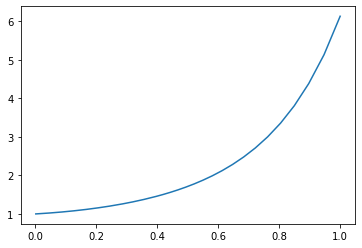

In [40]:
%pylab inline
plot(results.times,results.states)